In [20]:
from pathlib import Path
import shutil

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [9]:
candidate_dirs = [
    "data/custom_dataset/splits/access_v1",
    "../data/custom_dataset/splits/access_v1",
    "../../data/custom_dataset/splits/access_v1",
]

SPLIT_ROOT = None

print(f"Using data folder: {SPLIT_ROOT}")
LABELS = ["accept", "reject"]

for split in ["train", "val", "test"]:
    split_dir = SPLIT_ROOT / split
    if not split_dir.exists():
        raise FileNotFoundError(f"Missing split folder: {split_dir}")
    for label in LABELS:
        (split_dir / label).mkdir(parents=True, exist_ok=True)

    for img_path in split_dir.glob("*.png"):
        label = img_path.stem.split("_", 1)[0]
        dest = split_dir / label / img_path.name
        if not dest.exists():
            shutil.move(img_path, dest)

Using data folder: /Users/egecan/NOICLOUD/VoiceRecognition/data/custom_dataset/splits/access_v1


In [17]:
# Rescaling to [0, 1] (tutorial step)
base_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),  # converts PNGs to floats in [0, 1]
])

train_data = datasets.ImageFolder(SPLIT_ROOT / "train", transform=base_transform)
val_data = datasets.ImageFolder(SPLIT_ROOT / "val", transform=base_transform)
test_data = datasets.ImageFolder(SPLIT_ROOT / "test", transform=base_transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

print(f"Train: {len(train_data)} | Val: {len(val_data)} | Test: {len(test_data)}")
print("Classes:", train_data.classes)


Train: 3141 | Val: 393 | Test: 393
Classes: ['accept', 'reject']


In [18]:
# Cropping + adjusting augmentations for training only
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

train_data = datasets.ImageFolder(SPLIT_ROOT / "train", transform=train_transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
print("Augmented training set ready:", len(train_data), "samples")


Augmented training set ready: 3141 samples


In [19]:
batch, labels = next(iter(train_loader))
print("Batch tensor shape:", batch.shape)
print("Label tensor shape:", labels.shape)
print(f"Pixel value range after transforms: {batch.min().item():.3f} to {batch.max().item():.3f}")


Batch tensor shape: torch.Size([32, 3, 128, 128])
Label tensor shape: torch.Size([32])
Pixel value range after transforms: 0.000 to 0.996


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

In [23]:
# Simple CNN defined inline (no external module)
class SimpleVoiceCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, len(LABELS)),
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

model = SimpleVoiceCNN().to(device)
total_params = sum(p.numel() for p in model.parameters())
print(model)
print(f"Total parameters: {total_params:,}")


SimpleVoiceCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
)
Total parameters: 8,482,626


In [24]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [25]:
# Training loop (basic tutorial-style)
history = []
for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1)
        running_correct += (preds == targets).sum().item()
        total += targets.size(0)

    train_loss = running_loss / total
    train_acc = running_correct / total

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == targets).sum().item()
            val_total += targets.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total
    history.append({"epoch": epoch, "train_loss": train_loss, "train_acc": train_acc, "val_loss": val_loss, "val_acc": val_acc})
    print(f"Epoch {epoch:02d} | Train loss {train_loss:.4f} acc {train_acc:.3f} | Val loss {val_loss:.4f} acc {val_acc:.3f}")


Epoch 01 | Train loss 0.2352 acc 0.907 | Val loss 0.0244 acc 0.997
Epoch 02 | Train loss 0.0673 acc 0.978 | Val loss 0.0603 acc 0.977
Epoch 03 | Train loss 0.0619 acc 0.977 | Val loss 0.0276 acc 0.995
Epoch 04 | Train loss 0.0563 acc 0.978 | Val loss 0.0171 acc 0.995
Epoch 05 | Train loss 0.0501 acc 0.981 | Val loss 0.0104 acc 0.997
Epoch 06 | Train loss 0.0384 acc 0.987 | Val loss 0.0309 acc 0.985
Epoch 07 | Train loss 0.0287 acc 0.989 | Val loss 0.0152 acc 0.995
Epoch 08 | Train loss 0.0424 acc 0.983 | Val loss 0.0126 acc 0.995
Epoch 09 | Train loss 0.0288 acc 0.989 | Val loss 0.0144 acc 0.995
Epoch 10 | Train loss 0.0277 acc 0.988 | Val loss 0.0118 acc 0.995


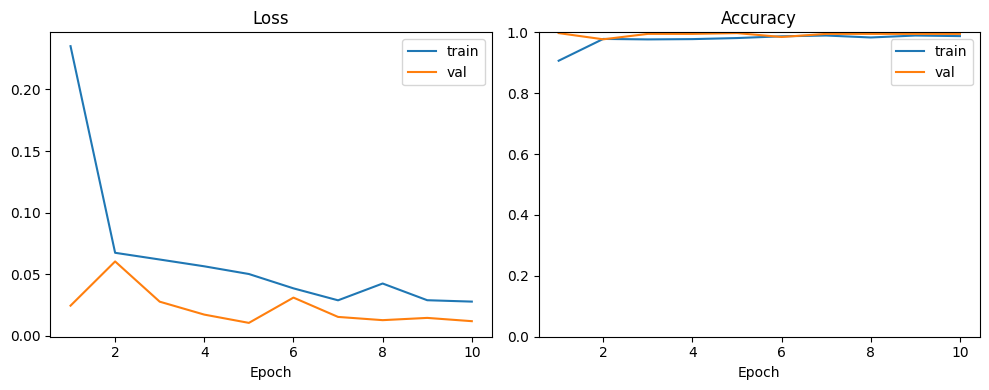

In [26]:
# Plot training curves
import matplotlib.pyplot as plt

epochs = [row["epoch"] for row in history]
train_losses = [row["train_loss"] for row in history]
val_losses = [row["val_loss"] for row in history]
train_accs = [row["train_acc"] for row in history]
val_accs = [row["val_acc"] for row in history]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="train")
plt.plot(epochs, val_losses, label="val")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label="train")
plt.plot(epochs, val_accs, label="val")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()


In [27]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1).cpu()
        all_preds.extend(preds.tolist())
        all_targets.extend(targets.tolist())

print(classification_report(all_targets, all_preds, target_names=LABELS, digits=4))


              precision    recall  f1-score   support

      accept     1.0000    0.8831    0.9379        77
      reject     0.9723    1.0000    0.9860       316

    accuracy                         0.9771       393
   macro avg     0.9862    0.9416    0.9619       393
weighted avg     0.9777    0.9771    0.9765       393

